## Fig. 5 Low-level cloud fraction vs proxyes

In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import xarray as xr
import os
import sys
sys.path.append('./scripts/')
from scipy import stats
import proplot as plot
from analysis_functions import add_datetime_info, get_unique_line_labels
import model_constants as mc
import metpy.calc
from metpy.units import units

In [2]:
def add_fitted_line_info(ax, slope, intercept, r_value, x, y, color='k', l_r2_str=False, fontsize=20):
    slope_str = "%.3f" % slope
    intercept_str = "%.3f" % np.abs(intercept)
    if l_r2_str:
        r_str = r'$R^2$= ' + "%.3f" % (r_value**2)
    else:
        r_str = r'$R$ = ' +"%.3f" % (r_value)
    if intercept>= 0:
        sign = r' $+$ '
    else:
        sign = r' $-$ '
    ax.text(x, y, r_str +'\n' +r'$y=$ '+slope_str + r'$x$' + sign + intercept_str, color=color, fontsize=fontsize)

In [3]:
def regional_mean(dt):
    return np.average(dt.mean('lon'), axis=dt.dims.index('lat'), weights=np.cos(np.deg2rad(dt.lat)))

def seasonal_regional_mean(dt):
    add_datetime_info(dt)
    dt_season = dt.groupby(dt.season).mean('time')
    dt_season_area_mean = []
    for i in range(len(dt_season.season)):
        dt_season_area_mean.append(regional_mean(dt_season[i,...]))
    return np.array(dt_season_area_mean)

In [4]:
def moist_lapse_rate_Gamma(T_in_K, p_in_hPa):
    T_in_C = T_in_K - 273.15
    # https://unidata.github.io/MetPy/latest/_modules/metpy/calc/thermo.html#saturation_vapor_pressure
    es = 6.1078 * np.exp(17.27 * T_in_C / (T_in_C+237.3))
    qs = 0.622 * es / (p_in_hPa - es)
    Gamma = (mc.grav / mc.cp) * (1.0 - (1.0 + mc.Lv * qs  /mc.RDGAS / T_in_K) 
            / (1.0 + mc.Lv**2 * qs / mc.cp / mc.RVGAS / T_in_K**2))
    return Gamma

def calc_theta(T_in_K, p_in_hPa):
    p0 = 1.0e3
    return T_in_K * (p0/p_in_hPa)**mc.kappa

#### Function to get different low-level cloud amount proxyes

In [5]:
def get_data_from_selected_years(dt_dir, fn_prefix, s_year, e_year):
    fnm = P(dt_dir, fn_prefix + str(s_year)+'_'+str(e_year)+'.nc')
    if not os.path.exists(fnm):
        # cdo selyear,XXXX/YYYY in.nc out.nc
        fnm1 = P(dt_dir, fn_prefix + '1979_2017.nc')
        os.system('cdo selyear,%s/%s %s %s'%(str(int(s_year)), str(int(e_year)), fnm1, fnm))
    return fnm


def get_observed_low_cf_proxy(s_year, e_year, out_fn):
    P = os.path.join
    dt_dir = '/scratch/ql260/obs_datasets/ecmwf_data/long_year_data'
    
    # ------------- ERA interim reanalysis ------------- #
    print('Read ERA-I begin...')
    print('read RH...')
    fnm = get_data_from_selected_years(dt_dir, 'ecmwf_rh_', s_year, e_year)
    ds_rh = xr.open_dataset(fnm, decode_times=False)
    add_datetime_info(ds_rh)
    rh = ds_rh.r #.where((ds_rh.year>=s_year) & (ds_rh.year<=e_year), drop=True)

    print('read sphum...')
    fnm = get_data_from_selected_years(dt_dir, 'ecmwf_sphum_', s_year, e_year)
    q_ds = xr.open_dataset(fnm, decode_times=False)
    add_datetime_info(q_ds)
    # q = q_ds.q.where((q_ds.year>=s_year) & (q_ds.year<=e_year), drop=True)
    q = q_ds.q
    q = xr.DataArray(q, coords=[q.time, q.level, q.latitude, q.longitude],
                     dims=['time', 'level', 'lat', 'lon'])

    print('read temperature...')
    fnm = get_data_from_selected_years(dt_dir, 'ecmwf_temperature_', s_year, e_year)
    t_ds = xr.open_dataset(fnm, decode_times=False)
    add_datetime_info(t_ds)
    t = t_ds.t # .where((t_ds.year>=s_year) & (t_ds.year<=e_year), drop=True)

    print('read spatial cld fraction...')
    fnm = get_data_from_selected_years(dt_dir, 'low_mid_high_tot_cld_amt_', s_year, e_year)
    cf_ds = xr.open_dataset(fnm, decode_times=False)
    add_datetime_info(cf_ds)
    #cf_ds = cf_ds.where((cf_ds.year>=s_year) & (cf_ds.year<=e_year), drop=True)

    try:
        lats = t_ds.lat
        lons = t_ds.lon
    except:
        lats = t_ds.latitude
        lons = t_ds.longitude

    levels = t_ds.level
    nlat = len(lats)
    nlon = len(lons)

    low_cld_frac = cf_ds.lcc * 1e2
    low_cld_frac = xr.DataArray(low_cld_frac, coords=[cf_ds.time, lats, lons],
                                dims=['time', 'lat', 'lon'])
    low_cld_frac_mean = low_cld_frac.mean('time')

    temp = xr.DataArray(t, coords=[t.time, levels, lats, lons], dims=['time', 'level', 'lat', 'lon'])
    t_mean = temp.mean('time')
    rh = xr.DataArray(rh, coords=[rh.time, levels, lats, lons], dims=['time', 'level', 'lat', 'lon'])
    rh_mean = rh.mean('time')

    # potential temperature
    print('Calc potential temperature...')
    p0 = 1.0e3
    theta = temp * (p0 / levels)**mc.kappa

    # ============= min of dtheta/dp ================== #
    # Slingo, J. M. (1987). The development and verification of a cloud
    # prediction scheme for the ECMWF model. QJRMS, 113(477), 899-927.
    # doi: 10.1002/qj.49711347710
    
    print('Calc min dtheta/dp...')
    dtheta = np.gradient(theta, axis=1)
    dtheta = xr.DataArray(dtheta,  coords=[theta.time, levels, lats, lons], 
                          dims=['time', 'level', 'lat', 'lon'])
    pdiff = np.gradient(levels, axis=0)
    pdiff = xr.DataArray(pdiff, coords=[levels], dims=['level'])
    dthdp1 = dtheta / pdiff

    mid_cld_base = 750.0
    dthdp2 = dthdp1.where(dthdp1.level > mid_cld_base)
    dthdp = dthdp2.fillna(0.0)
    min_dthdp = np.min(dthdp, axis=1)


    # =========== Lower Tropospheric Stability (LTS) ========= #
    # Klein, S. A., & Hartmann, D. L. (1993). The seasonal cycle 
    # of low stratiform clouds. Journal of Climate, 6(8), 1587-1606.
    # doi: 10.1175/1520-0442(1993)006<1587:tscols>2.0.co;2
    
    print('Calc LTS...')
    k700 =  min(range(len(levels)), key=lambda i: abs(levels[i]-7.0e2))
    print('The level closest to the 700hPa is %.2f'%levels[k700] + ' hPa.')
    LTS = theta[:,k700,:,:] - theta[:,-1,:,:]


    # =========== Estimated Inversion Stability (EIS) ========= #
    # Refer to: Wood and Bertherton, 2006, Journal of Climate
    #
    # EIS = LTS - Gamma_850_m * (z700-LCL)
    # LTS = theta_700 - theta_s

    print('Calc EIS...')
    
    print('Read surface pressure')
    fnm = get_data_from_selected_years(dt_dir, 'ecmwf_erai_ts_t2m_ps_', s_year, e_year)
    surf_ds = xr.open_dataset(fnm, decode_times=False)
    add_datetime_info(surf_ds)
    sp = surf_ds.sp / 1.0e2 #.where((surf_ds.year>=s_year) & (surf_ds.year<=e_year), drop=True) / 1.0e2
    sp = xr.DataArray(sp, coords=[sp.time, lats, lons], dims=['time', 'lat', 'lon'])

    print('Read surface temperature')
    tas = surf_ds.t2m #.where((surf_ds.year>=s_year) & (surf_ds.year<=e_year), drop=True)
    tas = xr.DataArray(tas, coords=[tas.time, lats, lons], dims=['time', 'lat', 'lon'])

    LTS =  temp[:,k700,:,:]*(p0/levels[k700])**mc.kappa - tas *(p0/sp)**mc.kappa
    T850 = (temp[:,k700,:,:] + tas) / 2.0
    Gamma_850 = moist_lapse_rate_Gamma(T850, 850.0)
    z700  = mc.RDGAS * tas / mc.grav * np.log(1.0e3 / levels[k700])

    # Calc LCL
    rh0 = 0.8
    tas_units = tas.values*units.kelvin
    dewpt = metpy.calc.dewpoint_rh(tas_units, rh0)
    (plcl, tlcl) = metpy.calc.lcl(sp.values*units.hPa, tas_units, dewpt)
    plcl = xr.DataArray(np.array(plcl), coords=[tas.time, lats, lons], dims=['time', 'lat', 'lon'])
    tlcl = xr.DataArray(np.array(tlcl)+273.15, coords=[tas.time, lats, lons], dims=['time', 'lat', 'lon'])
    zlcl = mc.RDGAS * tas / mc.grav * np.log(1e3/ plcl)
    EIS   = LTS - Gamma_850 * (z700-zlcl)

    
    # ============= Estimated Cloud-Top Entraiment Index (ECTEI) ============= #
    # Kawai, H., Koshiro, T., & Webb, M. J. (2017). Interpretation of factors controlling 
    # low cloud cover and low cloud feedback using a unified predictive index. 
    # Journal of Climate, 30(22), 9119-9131.
    # doi: 10.1175/jcli-d-16-0825.1
    
    print('Calc ECTEI...')
    k_en = 0.7
    C_qgap = 0.76
    beta = (1 - k_en) * C_qgap
    ECTEI = EIS - beta * mc.Lv / mc.cp * (q[:,-1,:,:] - q[:,k700,:,:])
    

    # =============== ELF: estimated low-level cloud fraction ================= #
    # Park, S., & Shin, J. (2019). Heuristic estimation of low-level cloud fraction
    #  over the globe based on a decoupling parameterization. 
    #  Atmospheric Chemistry and Physics, 19(8), 5635-5660.
    #  https://acp.copernicus.org/articles/19/5635/2019/
    
    print('Calc ELF...')
    
    delta_zs = 2750.0  # metre
    # ML is the LCL
    # For simplicity, we assume that z_ML=z_LCL over the entire globe. (Page 5638)
    Gamma_DL = moist_lapse_rate_Gamma(tlcl, plcl)
    Gamma_700 = moist_lapse_rate_Gamma(temp[:,k700,:,:], levels[k700])
    LTS_ML = theta[:,k700,:,:] - calc_theta(tlcl, plcl)

    # Eq(4) in Park and Shin (2019)
    z_inv = -LTS_ML / Gamma_700 + z700 + delta_zs * (Gamma_DL / Gamma_700)
    ind_z = np.array(z_inv<zlcl)
    z_inv.values[ind_z] = zlcl.values[ind_z]

    # Eq(7)
    beta1 = (z_inv + zlcl) / delta_zs
    # Eq(8)
    beta2 = np.sqrt(z_inv * zlcl) / delta_zs

    #q_ML = q_in_ML(levels, plcl, q)
    ptest = np.abs(plcl - levels)
    p_dim = ptest.dims.index('level')
    p_ind1 = np.argmin(ptest.values, axis=p_dim)
    p_ind = xr.DataArray(p_ind1, coords=[plcl.time, lats, lons], dims=['time', 'lat', 'lon'])
    q_ML = q[:,p_ind,:,:]

    # Eq(10) 
    f_para = np.array(q_ML / 0.003)
    f_para[f_para<0.15] = 0.15
    f_para[f_para>1] = 1.0
    f_para = xr.DataArray(f_para, coords=[q_ML.time, lats, lons], dims=['time', 'lat', 'lon'])
    
    # Eq(9) in Park and Shin (2019)
    ELF = f_para * (1-beta2)


    # =========== Save data into file ============ #
    times = low_cld_frac.time
    saved_dict={'low_cld_frac':low_cld_frac, 'min_dthdp': min_dthdp, 
                'LTS': LTS, 'EIS': EIS, 'ECTEI': ECTEI,
                'beta1': beta1, 'beta2': beta2, 'ELF': ELF}

    ds_save = xr.Dataset(saved_dict, coords={'time':times, 'lat':lats, 'lon':lons}) # level...
    ds_save.to_netcdf(out_fn, format='NETCDF3_CLASSIC', mode='w')
    print(out_fn + ' saved.')

In [6]:
P = os.path.join

fig_dir = './figs'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

save_dt_dir = './data'

s_year = 2013
e_year = 2017

# File stores the low cloud fraction and its proxies, time from 2013 t0 2017
proxy_fn = P(save_dt_dir, 'low_cf_proxy.nc')
if not os.path.exists(proxy_fn):
    get_observed_low_cf_proxy(s_year, e_year, proxy_fn)

ds = xr.open_dataset(proxy_fn, decode_times=False)

Read ERA-I begin...
read RH...
read sphum...
read temperature...
read spatial cld fraction...
Calc potential temperature...
Calc min dtheta/dp...
Calc LTS...
The level closest to the 700hPa is 700.00 hPa.
Calc EIS...
Read surface pressure
Read surface temperature
Calc ECTEI...
Calc ELF...
./data/low_cf_proxy.nc saved.


In [7]:
ds

<xarray.Dataset>
Dimensions:       (lat: 181, latitude: 181, lon: 360, longitude: 360, time: 60)
Coordinates:
  * time          (time) float64 9.906e+05 9.913e+05 ... 1.033e+06 1.034e+06
  * lat           (lat) float32 90.0 89.0 88.0 87.0 ... -87.0 -88.0 -89.0 -90.0
  * lon           (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    level         float64 ...
  * latitude      (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude     (longitude) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    low_cld_frac  (time, lat, lon) float32 ...
    min_dthdp     (time, lat, lon) float64 ...
    LTS           (time, lat, lon) float64 ...
    EIS           (time, lat, lon) float64 ...
    ECTEI         (time, lat, lon) float64 ...
    beta1         (time, lat, lon) float64 ...
    beta2         (time, lat, lon) float64 ...
    ELF           (time, lat, lon) float64 ...

In [8]:
# Diagnose stratocumulus (Sc) cloud fraction in different regions
#
# Table 1 from Klein and Hartmann, J. Climate, (1993)
# doi: https://doi.org/10.1175/JCLI3702.1
#
regions_dict = {'Peru':           {'lat':(-20.0, -10.0), 'lon': (360.0-90.0, 360.0-80.0)},
                'Namibia':        {'lat':(-20.0, -10.0), 'lon': (0.0, 10.0)}, 
                'California':     {'lat':(20.0, 30.0),   'lon': (360.0-130.0, 360.0-120.0)},
                'Australia':      {'lat':(-35.0, -25.0), 'lon': (95.0, 105.0)},
                'Canary':         {'lat':(15.0, 25.0),   'lon': (360.0-45.0, 360.0-35.0)},
                'North Pacific':  {'lat':(40.0, 50.0),   'lon': (170.0, 180.0)},
                'North Atlantic': {'lat':(50.0, 60.0),   'lon': (360.0-45.0, 360.0-35.0)},
                'China':          {'lat':(20.0, 30.0),   'lon': (105.0, 120)},
                }

print('Calculate regional mean...')
for region, range_dict in regions_dict.items():
    l_lat = np.logical_and(ds.lat >= range_dict['lat'][0], ds.lat <= range_dict['lat'][1])
    l_lon = np.logical_and(ds.lon >= range_dict['lon'][0], ds.lon <= range_dict['lon'][1])

    regions_dict[region]['low_cld_frac'] = ds.low_cld_frac.where(l_lat & l_lon, drop=True)
    regions_dict[region]['min_dthdp'] = ds.min_dthdp.where(l_lat & l_lon, drop=True)
    regions_dict[region]['LTS'] = ds.LTS.where(l_lat & l_lon, drop=True)
    regions_dict[region]['EIS'] = ds.EIS.where(l_lat & l_lon, drop=True)
    regions_dict[region]['ECTEI'] = ds.ECTEI.where(l_lat & l_lon, drop=True)
    regions_dict[region]['beta1'] = ds.beta1.where(l_lat & l_lon, drop=True)
    regions_dict[region]['beta2'] = ds.beta2.where(l_lat & l_lon, drop=True)
    regions_dict[region]['ELF'] = ds.ELF.where(l_lat & l_lon, drop=True)

Calculate regional mean...


Scatter plot begin...


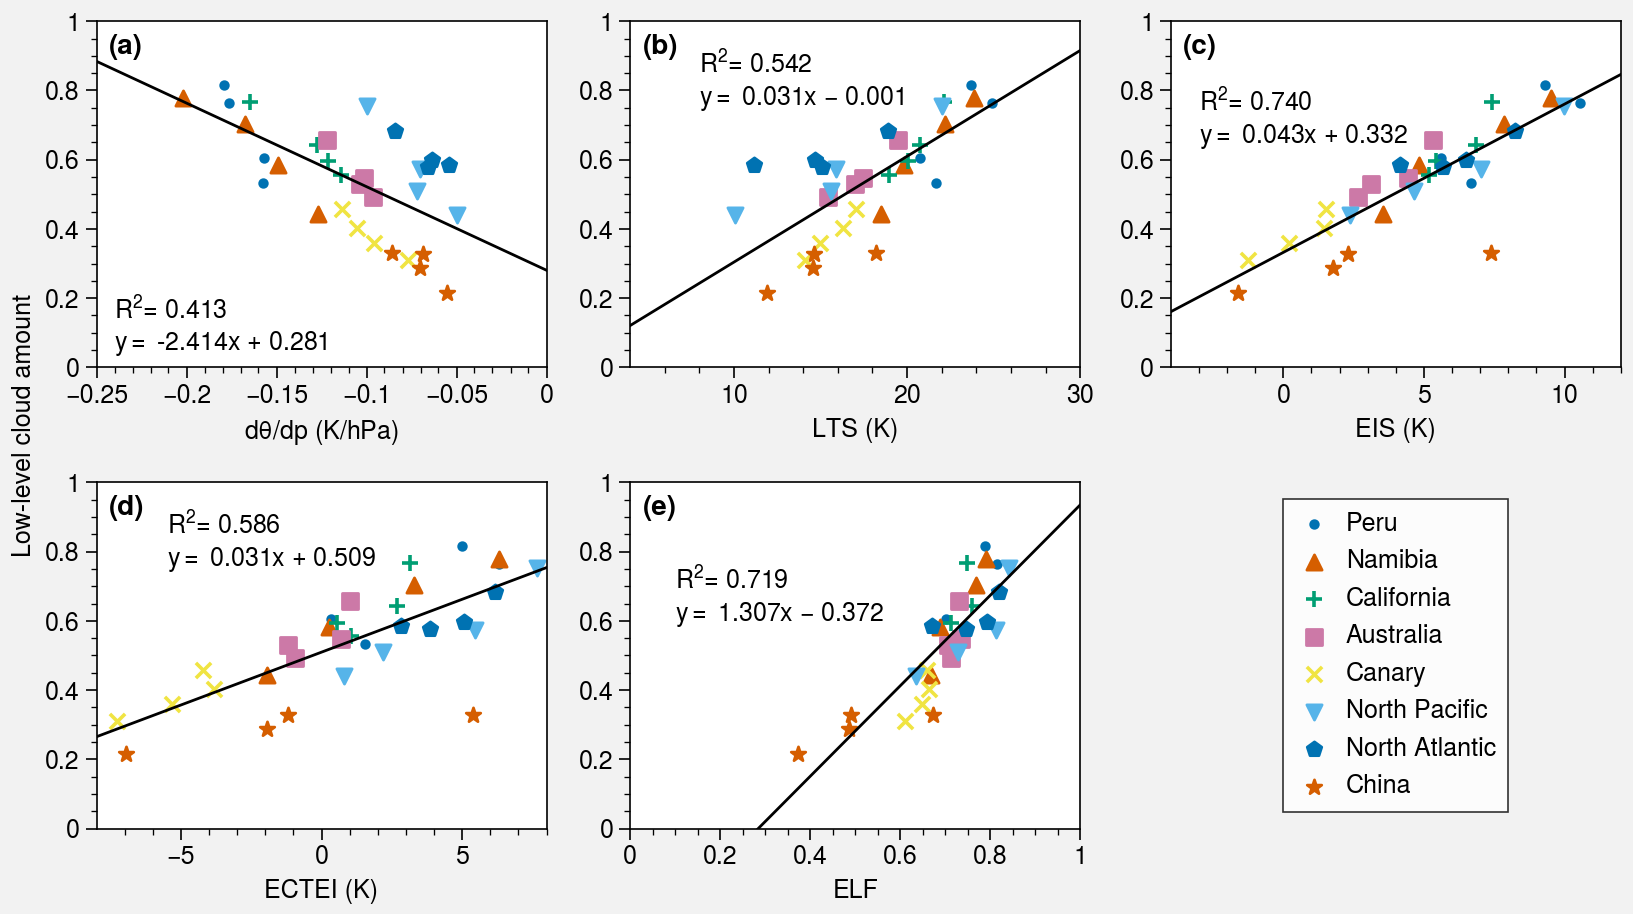

In [9]:
print('Scatter plot begin...')
plot.rc.reset()
var_names = ['min_dthdp', 'LTS', 'EIS', 'ECTEI',  'ELF']
xlabels = [r'd$\theta$/d$p$ (K/hPa)', 'LTS (K)',  'EIS (K)', 'ECTEI (K)', 'ELF']
xlim_arr = [[-0.25, 0], [4, 30], [-4, 12], [-8,8], [0,1]]
text_xy_arr = [[-0.24, 0.05], [8, 0.76], [-3, 0.65], [-5.5,0.76], [0.1,0.6]]
xbase_arr = [0.05, 5, 5, 3, 0.2]

plot.close()
nrows = 2
ncols = 3

fig, axes = plot.subplots(nrows=nrows, ncols=ncols, aspect=(1.3, 1), sharex=False, sharey=True)
axes[-1].axis("off") # No plots on the final axes

plot.rc['cycle'] = 'bmh'     #'default' #'ggplot'

region_shapes = ['.', '^', '+', 's', 'x', 'v', 'p', '*']
lines = []
for kk, (ax, varnm, xlabel, xlim, text_xy, xbase) in enumerate(zip(
        axes, var_names, xlabels, xlim_arr, text_xy_arr, xbase_arr)):
    # print(varnm)
    all_y = []
    all_x = []
    for i, (marker, (region, local_dt)) in enumerate(zip(region_shapes, regions_dict.items())):
        y = seasonal_regional_mean(local_dt['low_cld_frac'])/1e2
        x = seasonal_regional_mean(local_dt[varnm])
        all_x.extend(x)
        all_y.extend(y)
        line = ax.scatter(x, y, marker=marker, s=30, label=region)
        lines.append(line)

    ax.set_xlabel(xlabel)
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_x, all_y)
    x2 = np.linspace(min(xlim), max(xlim), 100)
    y2 = slope * x2 + intercept
    ax.plot(x2, y2, 'k-', linewidth=1)
    ax.set_xlim(xlim)
    add_fitted_line_info(ax, slope, intercept, r_value, text_xy[0], text_xy[1], l_r2_str=True, fontsize=9)

axes[0:-1].format(grid=False, title=r'',  # ytickminor=True, xtickminor=True,
                ylabel='Low-level cloud amount', ylim=[0, 1], abc=True, abcloc='ul', abcstyle='(a)')

new_lines, new_labels = get_unique_line_labels(lines)
axes[-1].legend(new_lines, new_labels, loc='c', ncol=1)

figname = P(fig_dir, 'low_cld_frac_vs_diff_vars_season.pdf')
fig.savefig(figname, bbox_inches='tight', pad_inches=0.1, tranparent=False)